In [1]:
"""
From
https://www.tensorflow.org/tutorials/audio/simple_audio
"""

'\nFrom\nhttps://www.tensorflow.org/tutorials/audio/simple_audio\n'

In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2022-06-23 17:08:39.185473: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [3]:
import string

class_names = [x for x in string.ascii_lowercase]
class_names = class_names + [str(x) for x in range(0, 10, 1)]

In [4]:
data_dir = pathlib.Path("./training_data")

filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/class_names[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 997
Number of examples per label: 33
Example file tensor: tf.Tensor(b'training_data/d/18.wav', shape=(), dtype=string)


2022-06-23 17:08:39.946915: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-06-23 17:08:40.835174: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2022-06-23 17:08:40.835216: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: flagship
2022-06-23 17:08:40.835222: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: flagship
2022-06-23 17:08:40.835369: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.129.6
2022-06-23 17:08:40.835392: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.103.1
2022-06-23 17:08:40.835397: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 470.103.1 does not match DSO version 470.129.6 -- c

In [5]:
train_files = filenames[:int(500 * 0.8)]
val_files = filenames[int(500 * 0.8): int(500 * 0.9)]
test_files = filenames[int(500 * 0.9):]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 400
Validation set size 50
Test set size 547


In [6]:
def decode_audio(audio_binary):
    # Decode WAV-encoded audio files to `float32` tensors, normalized
    # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
    audio, _ = tf.audio.decode_wav(contents=audio_binary)
    # Since all the data is single channel (mono), drop the `channels`
    # axis from the array.
    return tf.squeeze(audio, axis=-1)

In [7]:
def get_label(file_path):
    parts = tf.strings.split(
        input=file_path,
        sep=os.path.sep)
    # Note: You'll use indexing here instead of tuple unpacking to enable this
    # to work in a TensorFlow graph.
    return parts[-2]

In [8]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

In [30]:
def get_spectrogram(waveform):
    # Zero-padding for an audio waveform with less than 16,000 samples.
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
    # Cast the waveform tensors' dtype to float32.
    waveform = tf.cast(waveform, dtype=tf.float32)
    # Concatenate the waveform with `zero_padding`, which ensures all audio
    # clips are of the same length.
    equal_length = tf.concat([waveform, zero_padding], 0)
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [31]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: d
Waveform shape: (3105,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [32]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

In [33]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    label_id = tf.math.argmax(label == class_names)
    return spectrogram, label_id

In [34]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

In [35]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(
        map_func=get_waveform_and_label,
        num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(
        map_func=get_spectrogram_and_label_id,
        num_parallel_calls=AUTOTUNE)
    return output_ds

In [36]:
from tensorflow import keras 
model = keras.models.load_model('./saved_model/my_model')

In [37]:
from IPython.display import Audio 
Audio("./test/captcha_3ec61b826d9a478797a388cb3c114402.wav", autoplay=True)

In [42]:
from pydub import AudioSegment

new_audio = AudioSegment.from_wav("./test/captcha_3ec61b826d9a478797a388cb3c114402.wav",)
start = 3.3 * 1000
end = 3.8 * 1000
tmp_audio = new_audio[start:end]
tmp_audio.export("test.wav", format="wav")

<_io.BufferedRandom name='test.wav'>

In [58]:
Audio("./test.wav", autoplay=True)

In [73]:
Audio("./4.wav", autoplay=True)

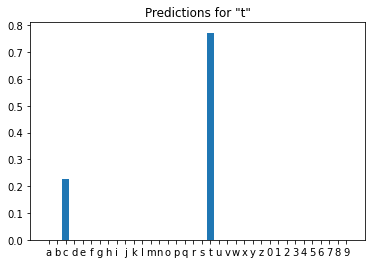

In [74]:
sample_file = "./4.wav"

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
    prediction = model(spectrogram)
    result = tf.nn.softmax(prediction[0]).numpy()
    list_result = result.tolist()
    max_val = max(result)
    max_val_index = list_result.index(max_val)
    
    class_label = class_names[max_val_index]
    
    plt.bar(class_names, tf.nn.softmax(prediction[0]))
    plt.title(f'Predictions for "{class_label}"')
    
    plt.show()

In [99]:
def predict_sound(file_name, graphing=False):
    sample_file = file_name
    sample_ds = preprocess_dataset([str(sample_file)])
    for spectrogram, label in sample_ds.batch(1):
        prediction = model(spectrogram)
        result = tf.nn.softmax(prediction[0]).numpy()
        list_result = result.tolist()
        max_val = max(result)
        max_val_index = list_result.index(max_val)

        class_label = class_names[max_val_index]

        if graphing:
            plt.bar(class_names, tf.nn.softmax(prediction[0]))
            plt.title(f'Predictions for "{class_label}"')
            plt.show()
            
    return class_label

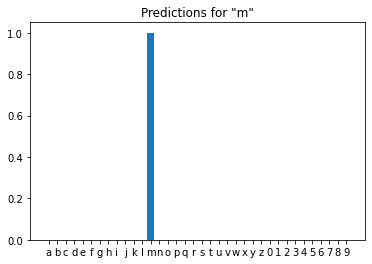

'm'

In [115]:
predict_sound("./0.wav", True)

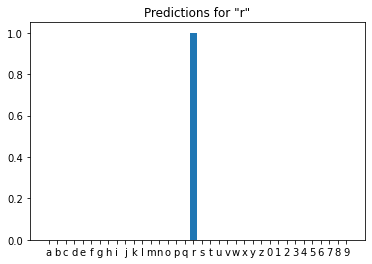

'r'

In [116]:
predict_sound("./1.wav", True)

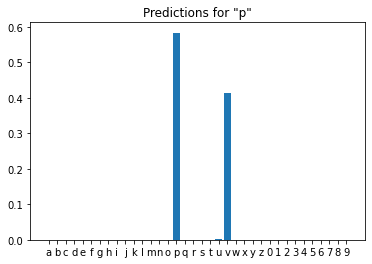

'p'

In [117]:
predict_sound("./2.wav", True)

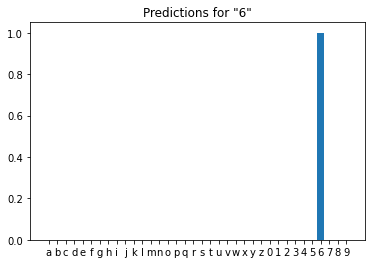

'6'

In [118]:
predict_sound("./3.wav", True)

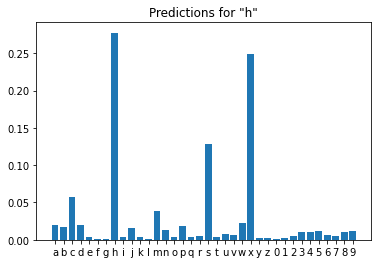

'h'

In [114]:
predict_sound("./4.wav", True)